## Project 1


### Import Dependencies

In [51]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
import datetime
import math
import random
import holoviews as hv
import hvplot.pandas
import panel as pn
from yahoo_fin import stock_info as si
from yahoo_earnings_calendar import YahooEarningsCalendar
from MCForecastTools import MCSimulation

In [52]:
# Load .env enviroment variables
initial_investment = 10000

from dotenv import load_dotenv
load_dotenv()

True

In [53]:
### Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)


In [54]:
#Ask User for intitial investment
investment_slider = pn.widgets.FloatSlider(name='Initial Investment', start=1000, end=100000, step=100, value=10000)

investment_slider

FloatSlider(end=100000, name='Initial Investment', start=1000, step=100, value=10000, value_throttled=10000)

### Dynamically Pull Stocks Based on Earnings Date

In [55]:
#Store initial investment
initial_investment = investment_slider.value
initial_investment

10000

In [56]:
#Ask the user for number of days to look at future earnings
day_slider = pn.widgets.FloatSlider(name='Please select the number of days to look at for earnings', start=1, end=25, step=1, value=2)

day_slider

FloatSlider(end=25, name='Please select t..., start=1, step=1, value=2, value_throttled=2)

In [57]:
#Store Selected days
furture_days = day_slider.value

In [58]:
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days = 2) 
start_time = tomorrow.strftime("%b %d %Y") + " 10:00AM"
next_day = today + datetime.timedelta(days = 3) 
end_time = next_day.strftime("%b %d %Y") + " 1:00PM"

date_from = datetime.datetime.strptime(
    start_time, '%b %d %Y %I:%M%p')
date_to = datetime.datetime.strptime(
    end_time, '%b %d %Y %I:%M%p')
yec = YahooEarningsCalendar()
stock_earnings = yec.earnings_between(date_from, date_to)


In [59]:
stock_list = [{'ticker': ticker['ticker'], 'epsestimate': ticker['epsestimate']} for ticker in stock_earnings if ticker['epsestimate']]
tickers = []
for i in stock_list:
    if i["ticker"] not in tickers:
        tickers.append((i["ticker"]))
        
print(tickers)

['ACN', 'AIR', 'APDN', 'RAD', 'NAV', 'CAMP', 'SCHL', 'FDX', 'SAFM', 'GIS', 'JBL', 'OTLK', 'SCS', 'WOR', 'APOG', 'CCL', 'DRI', 'WGO', 'NKE']


In [60]:
# Set timeframe to '1D'
timeframe = "1D"

#Set timeframe for last 2 years
start_date = pd.Timestamp("2018-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp(next_day, tz="America/New_York").isoformat()

#Get ticker data
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.head()

ACN                                        AIR  \
                             open     high       low   close   volume   open   
time                                                                           
2018-05-01 00:00:00-04:00  151.09  151.950  150.1200  151.88   821409  43.20   
2018-05-02 00:00:00-04:00  151.72  152.090  150.4100  150.69   891638  43.49   
2018-05-03 00:00:00-04:00  150.30  152.040  149.1400  151.68  1181445  43.20   
2018-05-04 00:00:00-04:00  150.71  153.955  150.3500  153.44  1094740  43.40   
2018-05-07 00:00:00-04:00  152.95  153.080  151.8408  152.32  1437543  44.49   

                                                            ...    WGO         \
                            high      low  close    volume  ...   open   high   
time                                                        ...                 
2018-05-01 00:00:00-04:00  43.57  42.5500  43.47  142770.0  ...  37.85  39.00   
2018-05-02 00:00:00-04:00  44.05  43.3500  43.41   64774.0  ...  38.75  39.90   
2018-05-03 00:00:00-04:00  43.74  42.8600  43.52   54483.0  ...  37.15  37.35   
2018-05-04 00:00:00-04:00  44.65  43.2900  44.39   66943.0  ...  36.80  38.20   
2018-05-07 00:00:00-04:00  45.49  44.0002  45.33   90957.0  ...  38.00  38.50   

                                                      WOR                \
                              low  close    volume   open   high    low   
time                                                                      
2018-05-01 00:00:00-04:00  37.525  38.65  497375.0  44.23  44.56  43.35   
2018-05-02 00:00:00-04:00  37.225  37.55  855989.0  44.59  44.82  43.97   
2018-05-03 00:00:00-04:00  35.800  36.95  462130.0  44.13  44.67  43.31   
2018-05-04 00:00:00-04:00  35.955  38.15  259106.0  43.53  44.69  43.24   
2018-05-07 00:00:00-04:00  36.200  38.40  584740.0  44.54  45.22  44.30   

                                            
                           close    volume  
time                                        
2018-05-01 00:00:00-04:00  44.37  214155.0  
2018-05-02 00:00:00-04:00  44.07  153262.0  
2018-05-03 00:00:00-04:00  43.75  179879.0  
2018-05-04 00:00:00-04:00  44.36  197542.0  
2018-05-07 00:00:00-04:00  45.19  187717.0  

[5 rows x 95 columns]

In [61]:
#Cleanup Pandas Data for Close Prices only
df_closing_prices = pd.DataFrame()

for ticker in tickers: 
    df_closing_prices[ticker] = df_ticker[ticker]["close"]

In [62]:
df_closing_prices.head()

ACN    AIR   APDN     RAD    NAV   CAMP   SCHL  \
time                                                                           
2018-05-01 00:00:00-04:00  151.88  43.47  1.500  1.6350  34.89  19.72  41.11   
2018-05-02 00:00:00-04:00  150.69  43.41  1.480  1.6400  34.96  19.96  41.27   
2018-05-03 00:00:00-04:00  151.68  43.52  1.499  1.6200  34.82  19.75  41.65   
2018-05-04 00:00:00-04:00  153.44  44.39  1.530  1.6382  35.67  19.76  41.66   
2018-05-07 00:00:00-04:00  152.32  45.33  1.545  1.6600  36.71  20.75  42.19   

                               FDX    SAFM    GIS     JBL  OTLK     SCS  \
time                                                                      
2018-05-01 00:00:00-04:00  244.750  113.41  43.54  26.690   NaN  13.450   
2018-05-02 00:00:00-04:00  240.615  114.27  42.48  27.020   NaN  13.675   
2018-05-03 00:00:00-04:00  242.180  112.48  41.21  27.125   NaN  13.800   
2018-05-04 00:00:00-04:00  244.920  112.55  42.54  27.440   NaN  14.100   
2018-05-07 00:00:00-04:00  243.110  111.06  42.33  27.420   NaN  13.550   

                             WOR   APOG    CCL     DRI    WGO    NKE  
time                                                                  
2018-05-01 00:00:00-04:00  44.37  42.33  64.09  93.270  38.65  68.09  
2018-05-02 00:00:00-04:00  44.07  41.93  62.85  91.980  37.55  68.25  
2018-05-03 00:00:00-04:00  43.75  41.71  62.81  91.820  36.95  66.90  
2018-05-04 00:00:00-04:00  44.36  42.15  63.08  92.820  38.15  68.12  
2018-05-07 00:00:00-04:00  45.19  42.51  62.92  91.905  38.40  69.32

In [63]:
#Generate Closing Price Graph
df_closing_prices.index = df_closing_prices.index.date

daily_close = df_closing_prices.hvplot.line()
daily_close

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [64]:
#Generate Daily Returns Graph 
df_daily_returns = df_closing_prices.pct_change().dropna()

daily_returns = df_daily_returns.hvplot.line()
daily_returns

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [65]:
### Dynamically Generate Weights 

In [66]:
total = 1
weight_list = []
#portfolios = 5
#for num in range(len(portfolios)):
for i in range(len(tickers)):
    if i == (len(tickers)-1):
        weight_list.append(round(total,2))
    elif len(tickers) > 1 and len(tickers) <= 5:
        weight = (round(random.uniform(0,total),2))
        weight_list.append(round(weight,2))
        total -= weight
    elif len(tickers) > 5:
        weight = (round(random.uniform(0.1,total)/3,8))
        weight_list.append(round(weight,2))
        total -= weight        
    else:
        weight_list.append(1.0)
print(weight_list)

[0.2, 0.04, 0.11, 0.11, 0.13, 0.11, 0.06, 0.04, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.03, 0.01, -0.01, -0.05]


In [67]:
df_weights = pd.DataFrame(index=["Weights"])

for ticker in tickers: 
    df_weights[ticker] = weight_list[tickers.index(ticker)]
df_weights.head()

ACN   AIR  APDN   RAD   NAV  CAMP  SCHL   FDX  SAFM   GIS   JBL  \
Weights  0.2  0.04  0.11  0.11  0.13  0.11  0.06  0.04  0.03  0.04  0.03   

         OTLK   SCS   WOR  APOG   CCL   DRI   WGO   NKE  
Weights  0.03  0.03  0.03  0.02  0.03  0.01 -0.01 -0.05

In [68]:
df_weights = df_weights.hvplot.heatmap()
df_weights

:HeatMap   [columns,index]   (value)

### The MCForecastTools Library at a Glance

### Simulate five year portfolio growth using Monte Carlo simulation

In [69]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_ticker,
    weights = weight_list,
    num_simulation = 500,
    num_trading_days = 252*5
)

In [70]:
# Printing the simulation input data
MC_fiveyear.portfolio_data.head()

ACN                                      \
                             open     high       low   close   volume   
time                                                                    
2018-05-01 00:00:00-04:00  151.09  151.950  150.1200  151.88   821409   
2018-05-02 00:00:00-04:00  151.72  152.090  150.4100  150.69   891638   
2018-05-03 00:00:00-04:00  150.30  152.040  149.1400  151.68  1181445   
2018-05-04 00:00:00-04:00  150.71  153.955  150.3500  153.44  1094740   
2018-05-07 00:00:00-04:00  152.95  153.080  151.8408  152.32  1437543   

                                          AIR                         ...  \
                          daily_return   open   high      low  close  ...   
time                                                                  ...   
2018-05-01 00:00:00-04:00          NaN  43.20  43.57  42.5500  43.47  ...   
2018-05-02 00:00:00-04:00    -0.007835  43.49  44.05  43.3500  43.41  ...   
2018-05-03 00:00:00-04:00     0.006570  43.20  43.74  42.8600  43.52  ...   
2018-05-04 00:00:00-04:00     0.011603  43.40  44.65  43.2900  44.39  ...   
2018-05-07 00:00:00-04:00    -0.007299  44.49  45.49  44.0002  45.33  ...   

                              WGO                                  WOR         \
                              low  close    volume daily_return   open   high   
time                                                                            
2018-05-01 00:00:00-04:00  37.525  38.65  497375.0          NaN  44.23  44.56   
2018-05-02 00:00:00-04:00  37.225  37.55  855989.0    -0.028461  44.59  44.82   
2018-05-03 00:00:00-04:00  35.800  36.95  462130.0    -0.015979  44.13  44.67   
2018-05-04 00:00:00-04:00  35.955  38.15  259106.0     0.032476  43.53  44.69   
2018-05-07 00:00:00-04:00  36.200  38.40  584740.0     0.006553  44.54  45.22   

                                                                
                             low  close    volume daily_return  
time                                                            
2018-05-01 00:00:00-04:00  43.35  44.37  214155.0          NaN  
2018-05-02 00:00:00-04:00  43.97  44.07  153262.0    -0.006761  
2018-05-03 00:00:00-04:00  43.31  43.75  179879.0    -0.007261  
2018-05-04 00:00:00-04:00  43.24  44.36  197542.0     0.013943  
2018-05-07 00:00:00-04:00  44.30  45.19  187717.0     0.018711  

[5 rows x 114 columns]

In [71]:
# Running a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2             3         4         5    \
0     1.000000  1.000000  1.000000  1.000000e+00  1.000000  1.000000   
1     1.164070  1.082906  0.990908  1.299127e+00  0.718569  1.109980   
2     1.121777  0.949623  0.831035  9.858368e-01  0.725282  0.989997   
3     0.760419  0.743818  0.727799  6.154369e-01  0.753756  0.670932   
4     0.767583  0.746707  0.591402  6.519057e-01  0.751551  0.562233   
5     0.623564  1.075777  0.614931  4.604289e-01  0.815506  0.580719   
6     0.640879  1.170291  0.484804  4.915349e-01  0.836716  0.656218   
7     0.851984  1.048088  0.533224  4.262552e-01  1.063992  0.795935   
8     0.936910  0.889592  0.494050  3.784486e-01  0.900556  0.883079   
9     1.057884  0.990000  0.492742  3.115727e-01  1.173926  0.786019   
10    1.232371  0.751993  0.554647  3.206560e-01  1.053749  0.900933   
11    1.276051  0.779277  0.497314  3.121468e-01  1.012179  0.900205   
12    1.194058  0.809407  0.456396  3.170339e-01  0.701262  0.605547   
13    0.923553  0.769309  0.569989  3.266907e-01  0.606105  0.464242   
14    1.061009  0.788209  0.417160  3.514609e-01  0.528804  0.511603   
15    0.793853  0.817110  0.340684  3.596866e-01  0.662077  0.465040   
16    0.905964  0.673129  0.288288  3.793611e-01  0.649553  0.413729   
17    0.761888  0.657699  0.308803  7.939919e-02  0.580532  0.451926   
18    0.672916  0.631118  0.351203  7.228239e-02  0.579874  0.575883   
19    0.668903  0.698382  0.460229  8.857903e-02  0.585304  0.628601   
20    0.547134  0.697696  0.534630  1.018829e-01  0.723768  0.653536   
21    0.387395  0.507428  0.614241  8.921162e-02  0.908887  0.588458   
22    0.323184  0.538052  0.650320  8.926250e-02  0.915503  0.655155   
23    0.316499  0.754704  0.584425  6.655161e-02  0.845466  0.501214   
24    0.296404  0.913483  0.679896  5.541019e-02  0.580291  0.558792   
25    0.182539  0.818868  0.675786  4.800530e-02  0.748263  0.653733   
26    0.156849  0.731217  0.748495  4.590116e-02  1.026997  0.641208   
27    0.131890  0.672924  0.725932  5.046031e-02  0.829143  0.557381   
28    0.182122  0.714395  0.709727  4.324526e-02  0.831243  0.530089   
29    0.211055  0.829017  0.897464  5.170289e-02  0.927650  0.519506   
...        ...       ...       ...           ...       ...       ...   
1231  0.086214  0.000170  0.082864  6.039346e-10  0.002035  0.000120   
1232  0.077928  0.000193  0.087097  7.237666e-10  0.002094  0.000151   
1233  0.068904  0.000210  0.062216  5.727463e-10  0.002724  0.000201   
1234  0.087268  0.000126  0.054774  5.169770e-10  0.002894  0.000186   
1235  0.101106  0.000132  0.040637  4.434640e-10  0.002973  0.000169   
1236  0.110322  0.000147  0.041038  4.371377e-10  0.002354  0.000147   
1237  0.121519  0.000189  0.046015  3.777498e-10  0.003497  0.000177   
1238  0.104034  0.000223  0.054427  2.722834e-10  0.004634  0.000194   
1239  0.072637  0.000128  0.057874  4.779512e-10  0.004889  0.000218   
1240  0.071639  0.000134  0.054751  4.978446e-10  0.004922  0.000256   
1241  0.065150  0.000095  0.058194  4.003289e-10  0.005579  0.000290   
1242  0.062870  0.000141  0.069178  3.479779e-10  0.006136  0.000288   
1243  0.065866  0.000174  0.063515  3.098779e-10  0.006619  0.000216   
1244  0.058622  0.000168  0.062606  2.763321e-10  0.005171  0.000204   
1245  0.062529  0.000163  0.072369  1.809822e-10  0.006094  0.000176   
1246  0.045508  0.000141  0.098410  2.030690e-10  0.007717  0.000185   
1247  0.037721  0.000167  0.105780  2.064092e-10  0.004636  0.000118   
1248  0.035985  0.000202  0.076569  1.723556e-10  0.004148  0.000147   
1249  0.033376  0.000214  0.089693  1.885122e-10  0.004019  0.000185   
1250  0.039546  0.000196  0.070619  1.952619e-10  0.003880  0.000183   
1251  0.046057  0.000191  0.085274  2.249871e-10  0.003529  0.000201   
1252  0.039848  0.000192  0.127087  1.728376e-10  0.003137  0.000181   
1253  0.053778  0.000167  0.126632  1.712762e-10  0.003608  0.000196   
1254  0.054126  0.000178  0.138069  2.205836e-10  0

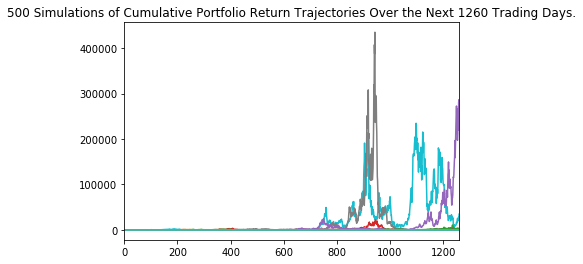

In [72]:
# Plot simulation outcomes
line_plot = MC_fiveyear.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

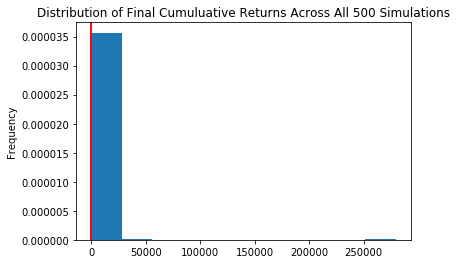

In [73]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyear.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [74]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
tbl

count           5.000000e+02
mean            6.443625e+02
std             1.258433e+04
min             5.407412e-15
25%             8.672691e-07
50%             6.685147e-05
75%             7.754713e-03
max             2.792910e+05
95% CI Lower    5.810537e-11
95% CI Upper    3.933864e+01
Name: 1260, dtype: float64

In [75]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in Coca-Cola and Microsoft stocks
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $10000 in the portfolio over the next 5 years will end within in the range of $0.0 and $393386.39


In [76]:
portfolio = {}
for ticker in tickers:
    stock_weight = weight_list[tickers.index(ticker)] * initial_investment
    current_stock_price = round(si.get_live_price(ticker),2)
    portfolio_weight = stock_weight//current_stock_price
    portfolio[ticker] = math.floor(portfolio_weight)

for key in portfolio.keys():
    mystring = f"Buy {key}: {portfolio[key]} shares"
    print(mystring)

Buy ACN: 8 shares
Buy AIR: 11 shares
Buy APDN: 188 shares
Buy RAD: 59 shares
Buy NAV: 29 shares
Buy CAMP: 100 shares
Buy SCHL: 22 shares
Buy FDX: 1 shares
Buy SAFM: 2 shares
Buy GIS: 6 shares
Buy JBL: 7 shares
Buy OTLK: 230 shares
Buy SCS: 21 shares
Buy WOR: 5 shares
Buy APOG: 6 shares
Buy CCL: 13 shares
Buy DRI: 0 shares
Buy WGO: -2 shares
Buy NKE: -4 shares


In [77]:
df_shares = pd.DataFrame(list(portfolio.items()),columns = ['ticker','shares'])
df_shares.set_index(['ticker'], inplace=True)
df_shares

shares
ticker        
ACN          8
AIR         11
APDN       188
RAD         59
NAV         29
CAMP       100
SCHL        22
FDX          1
SAFM         2
GIS          6
JBL          7
OTLK       230
SCS         21
WOR          5
APOG         6
CCL         13
DRI          0
WGO         -2
NKE         -4

In [78]:
#plot = df_shares.plot.pie(subplots=True,figsize=(5, 5))

2020-12-15 17:59:24,239 param.panel_extension WARNING  A HoloViz extension was loaded previously. This means the extension is already initialized and the following Panel extensions could not be properly loaded: ['plotly']. If you are loading custom extensions with pn.extension(...) ensure that this is called before any other HoloViz extension such as hvPlot or HoloViews.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
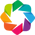

In [79]:
# imports
import panel as pn
import numpy as np
pn.extension('plotly')
import holoviews as hv
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
pn.extension()
import holoviews as hv
import holoviews.plotting.bokeh
hv.extension('bokeh')


In [80]:
closing_line= df_closing_prices.hvplot.line()
closing_line

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [81]:
return_line= df_daily_returns.hvplot.line()
return_line


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [82]:
df_closing_prices.head()

ACN    AIR   APDN     RAD    NAV   CAMP   SCHL      FDX  \
2018-05-01  151.88  43.47  1.500  1.6350  34.89  19.72  41.11  244.750   
2018-05-02  150.69  43.41  1.480  1.6400  34.96  19.96  41.27  240.615   
2018-05-03  151.68  43.52  1.499  1.6200  34.82  19.75  41.65  242.180   
2018-05-04  153.44  44.39  1.530  1.6382  35.67  19.76  41.66  244.920   
2018-05-07  152.32  45.33  1.545  1.6600  36.71  20.75  42.19  243.110   

              SAFM    GIS     JBL  OTLK     SCS    WOR   APOG    CCL     DRI  \
2018-05-01  113.41  43.54  26.690   NaN  13.450  44.37  42.33  64.09  93.270   
2018-05-02  114.27  42.48  27.020   NaN  13.675  44.07  41.93  62.85  91.980   
2018-05-03  112.48  41.21  27.125   NaN  13.800  43.75  41.71  62.81  91.820   
2018-05-04  112.55  42.54  27.440   NaN  14.100  44.36  42.15  63.08  92.820   
2018-05-07  111.06  42.33  27.420   NaN  13.550  45.19  42.51  62.92  91.905   

              WGO    NKE  
2018-05-01  38.65  68.09  
2018-05-02  37.55  68.25  
2018-05-03  36.95  66.90  
2018-05-04  38.15  68.12  
2018-05-07  38.40  69.32

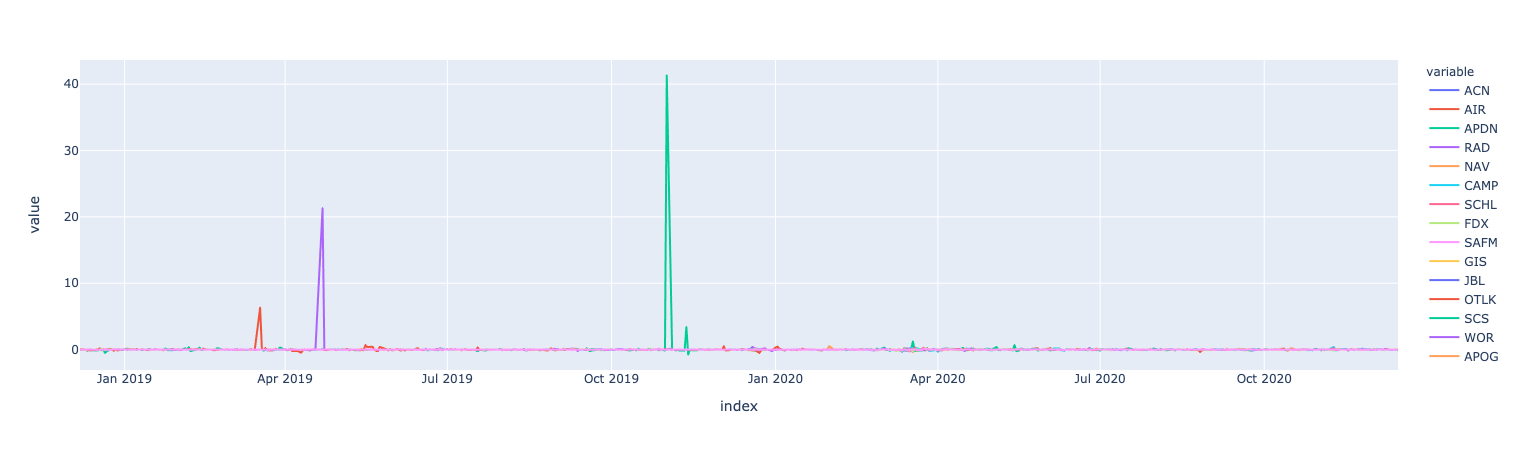

In [83]:
return_line_graph = px.line(df_daily_returns)
return_line_graph.show()

In [84]:
sharpe_ratios = (df_daily_returns.mean() * 252) / (df_daily_returns.std() * np.sqrt(252))
Sharpe_ratio_plot=sharpe_ratios.hvplot.bar(title= "Sharpe Ratios")
Sharpe_ratio_plot

:Bars   [index]   (0)

In [85]:
plot = df_shares.hvplot.bar(size=10)
plot

:Bars   [ticker]   (shares)

In [86]:
tbl = MC_fiveyear.summarize_cumulative_return()
tbl

count           5.000000e+02
mean            6.443625e+02
std             1.258433e+04
min             5.407412e-15
25%             8.672691e-07
50%             6.685147e-05
75%             7.754713e-03
max             2.792910e+05
95% CI Lower    5.810537e-11
95% CI Upper    3.933864e+01
Name: 1260, dtype: float64

In [87]:
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)
text = pn.pane.Markdown(f" **Summary** : There is a **95%** chance that an initial investment of **${initial_investment}** in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" **${ci_lower}** and **${ci_upper}**")

text2 = pn.pane.Markdown(f" **Portfolio Forecasting** : Let's determine your returns based on an initial investment of your choosing.")

In [88]:
investment_slider1 = pn.widgets.FloatSlider(name='Initial Investment', start=1000, end=100000, step=100, value=10000)
day_slider = pn.widgets.FloatSlider(name='Please select the number of days to look at for earnings', start=1, end=25, step=1, value=2)

tabs = pn.Tabs(('Daily Returns ',return_line_graph),
               ('Sharpe Ratios',Sharpe_ratio_plot), 
              ('Closing Price',closing_line),

              ('Share', plot),)

Dashboard = pn.Row(pn.Column('### Portfolio Analysis',text,investment_slider1,day_slider,width=400), tabs ,width=900)


Dashboard.servable()

Row(width=900)
    [0] Column(width=400)
        [0] Markdown(str)
        [1] Markdown(str)
        [2] FloatSlider(end=100000, name='Initial Investment', start=1000, step=100, value=10000, value_throttled=10000)
        [3] FloatSlider(end=25, name='Please select t..., start=1, step=1, value=2, value_throttled=2)
    [1] Tabs
        [0] Plotly(Figure, name='Daily Returns ')
        [1] HoloViews(Bars, name='Sharpe Ratios')
        [2] HoloViews(NdOverlay, name='Closing Price')
        [3] HoloViews(Bars, name='Share')

In [89]:
pn.serve(Dashboard)

Launching server at http://localhost:50563
